This is a walkthrough of an HTS analysis workflow using the Somoclu library to generate a SOM.  This is notebook is kind of a stream of conciousness walkthrough.  I even go through and approach that didn't work, then try something else that worked better. 


First, we need to import a bunch of libraries. If you've installed the RDKit you should already have most of this. The only libraries you should have to install are somoclu, tqdm and seaborn. 

```
pip install somoclu, tqdm, seaborn
```

In [1]:
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from tqdm import tqdm
import pandas as pd
import numpy as np
import math
from time import time
from somoclu import Somoclu
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import sys
from collections import Counter
import seaborn as sns
from rdkit.Chem import Draw


For this example, we'are going to take a look at an HTS dataset from PubChem.  The dataset is [CDK5 HTS with PubChem AID 488839](https://pubchem.ncbi.nlm.nih.gov/bioassay/488839). First off we will use the RDKit to read the chemical structures from the supplied. The code below reads the SD file and puts the SMILES and molecule name into a list.

In [2]:
suppl = Chem.SDMolSupplier("1502027397542988409.sdf")
smiles_list = []
for mol in tqdm(suppl):
    smiles_list.append([Chem.MolToSmiles(mol),mol.GetProp("_Name")])

100%|██████████| 334758/334758 [02:36<00:00, 2144.81it/s]


For convenience, we convert the list to a Pandas dataframe. The molecule name in the SD file corresponds to the PubChem Substance ID (SID).

In [3]:
mol_df = pd.DataFrame(smiles_list,columns=["SMILES","PUBCHEM_SID"])

Now we'll read the data from the PubChem csv file into another dataframe. The first three rows after the header in the CSV file contain information that we don't need, so we'll skip those. 

In [4]:
data_df = pd.read_csv("AID_488839_datatable.csv",
                      dtype={"PUBCHEM_SID": object},
                      skiprows=[1,2,3],
                      low_memory=False)

As a final step in our data preparation, we'll merge the two dataframes we created.  We use the PUBCHEM_SID field in the two files as a common key to join the dataframes. 

In [5]:
combo_df = mol_df.merge(data_df[["PUBCHEM_SID","PUBCHEM_ACTIVITY_OUTCOME"]],on="PUBCHEM_SID")

A few functions to generate fingerprints. The first function generates 166-bit MACCS keys.  The second generates Morgan fingerprints.  While both will work for building a SOM, the process will be a bit faster with MACCS keys. I tend to like MACCS keys for generating SOMs.  These fingerprints typically do a good job of grouping a set of molecules by scaffold. The third function takes a list of SMILES as input and returns as a list of fingerprints. If this function is called with one argument, it generates MACCS keys.  We can also pass a function as a second argument to generate a different fingerprint type.  For instance, we could call it like this to generate Morgan fingerprints.  
```
generate_fps(my_smiles_list,morgan_as_np)
```

In [6]:
def maccs_as_np(mol):
    """
    Generate MACCS fingerprints as a NumPy array
    :param mol: input molecule
    :return: fingerprint as a NumPy array
    """
    bv = MACCSkeys.GenMACCSKeys(mol)
    return np.array([int(x) for x in list(bv.ToBitString())], dtype=np.float32)


def morgan_as_np(mol):
    """
    Generate a 1024 bit Morgan fingerprint as a NumPy array
    :param mol: input molecule
    :return: fingerprint as a NumPy array
    """
    bv = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=1024)
    arr = np.zeros((1,), dtype=np.float32)
    DataStructs.ConvertToNumpyArray(bv, arr)
    return arr


def generate_fps(smiles_list, fp_function=maccs_as_np):
    """
    Take a list of SMILES as input and return a list of NumPy arrays
    :param smiles_list: list of SMILES
    :param fp_function: function to calculate fingerprints
    :return: list of NumPy arrays containing fingerprints
    """
    output_fp_list = []
    for smiles in tqdm(smiles_list, desc="Generating Fingerprints"):
        output_fp_list.append(fp_function(Chem.MolFromSmiles(smiles)))
    return output_fp_list

Define two functions for generating a SOM with Somoclu, the first function trains the SOM.  The second function uses the trained SOM to assign the best matching unit (BMU) to each fingerprint.  We are doing it this way so that we can train on a subset of the fingerprints and predict on the entire set. 

In [11]:
def train_somoclu_som(fp_list_in, x_dim=10, y_dim=10, use_gpu=False, num_epochs=10):
    """
    Train a SOM with Somoclu
    :param fp_list_in: List of fingerprints for molecule input
    :param x_dim: X dimension of the SOM
    :param y_dim: Y dimension of the SOM
    :param use_gpu: use a GPU (typically makes the calculation slower)
    :param num_epochs: Number of epochs for training
    :return: The trained SOM
    """
    print(len(fp_list_in))
    print("Training SOM")
    start_time = time()
    som = Somoclu(x_dim, y_dim, compactsupport=False, initialization="pca",kerneltype=int(use_gpu))
    som.train(fp_list_in,epochs=num_epochs)
    elapsed_time = time()-start_time
    print("Done\nElapsed time = %.2f sec" % elapsed_time)
    return som
    

def find_somoclu_bmu(som_in,fp_list_in):
    """
    Find the best matching unit (BMU) for a set of fingerprints
    :param som_in: Trained SOM
    :param fp_list_in: Input fingerprint list
    :return: X and Y coordinates in the SOM for the BMU
    """
    start_time = time()
    print("Finding BMUs")
    bmus = som_in.get_bmus(my_som.get_surface_state(fp_list_in))
    x_list = [x[0] for x in bmus]
    y_list = [x[1] for x in bmus]
    # find best matching units
    elapsed_time = time()-start_time
    print("Done\nElapsed time = %.2f sec" % elapsed_time)
    return x_list, y_list

Generate a fingerprints for our molecules, thsi time we will use Morgan fingerprints.

In [7]:
fp_list = generate_fps(combo_df["SMILES"],morgan_as_np)

Generating Fingerprints: 100%|██████████| 334758/334758 [02:46<00:00, 2015.01it/s]


Select a random subset of 10% of the fingerprints as a training set.  I'm not aware of any specific guidelines for selecting a subset, but in my hands, 10% works well for large sets like this. 

In [8]:
num_samples = int(len(fp_list)*0.1)
fp_list = np.array(fp_list)
train_fps = fp_list[np.random.choice(len(fp_list), num_samples, replace=False)]

The docs for MiniSOM recommend the number of cells in the SOM to be sqrt(number of molecules) * 5. 

In [9]:
math.sqrt(math.sqrt(num_samples)*5)

30.24580505089258

Train a 30x30 SOM on the training set. I haven't seen guidelines for the number of epochs.  The author of Somoclu recommends 10 epochs as a good starting point.  That's what I did and the results seem reasonable. 

In [26]:
my_som = train_somoclu_som(train_fps,30,30,num_epochs=10,use_gpu=False)

33475
Training SOM
Done
Elapsed time = 391.97 sec


Now find the best matching unit for each fingerprint based on the previously trained SOM. 

In [13]:
x,y = find_somoclu_bmu(my_som,fp_list)

Finding BMUs
Done
Elapsed time = 401.53 sec


Add the X and Y coordinates of the BMU to our dataframe. 

In [14]:
combo_df["X"] = x
combo_df["Y"] = y

Take a look at the first few lines of the dataframe to make sure it makes sense. 

In [15]:
combo_df.head()

,SMILES,PUBCHEM_SID,PUBCHEM_ACTIVITY_OUTCOME,X,Y
0,CCCCCCCCNS(=O)(=O)CCNCCCC,93577678,Inactive,20,11
1,CCCCCCCCNS(=O)(=O)CCNC1CC1,93577677,Inactive,11,18
2,O=S(=O)(CCNC1CC1)NC1CCCCC1,93577676,Inactive,15,25
3,CCCCCCCCNCCS(=O)(=O)NCCCCCCCC,93577675,Inactive,20,11
4,CCCCCCCCNCCS(=O)(=O)NC1CCCCC1,93577674,Inactive,15,25


A function to create a depiction of the SOM.  In this depiction, each cell is shown as a pie chart. Molecules labeled as active will be in an orange pie slide, molecules labeled as inactive will be in a blue pie slice.  

In [16]:
def depict_som(cluster_df, x_dim, y_dim, x_column="X", y_column="Y", act_column="active"):
    """
    Draw a SOM with each cell depicted as a pie chart
    :param cluster_df: data frame with SOM output, should have columns active, X, and Y
    :param x_dim: X dimension of the SOM
    :param y_dim: Y dimension of the SOM
    :return:
    """
    required_colums = [x_column, y_column, act_column]
    for col in required_colums:
        if col not in cluster_df.columns:
            print(f"Error {col} not in dataframe columns", file=sys.stderr)
            sys.exit(1)
    cell_dict = {}
    for k, v in [x for x in cluster_df.groupby([x_column, y_column])]:
        cell_dict[k] = Counter(v[act_column])
    cell_names = cluster_df[act_column].unique()
    plt.figure(figsize=(x_dim, y_dim))
    the_grid = GridSpec(x_dim, y_dim)
    for position in cell_dict.keys():
        label_fracs = [cell_dict[position][l] for l in cell_names]
        plt.subplot(the_grid[(x_dim - 1) - position[1], position[0]], aspect=1)
        plt.pie(label_fracs)

Now draw the SOM contents, note the we are passing the name for our activity column.

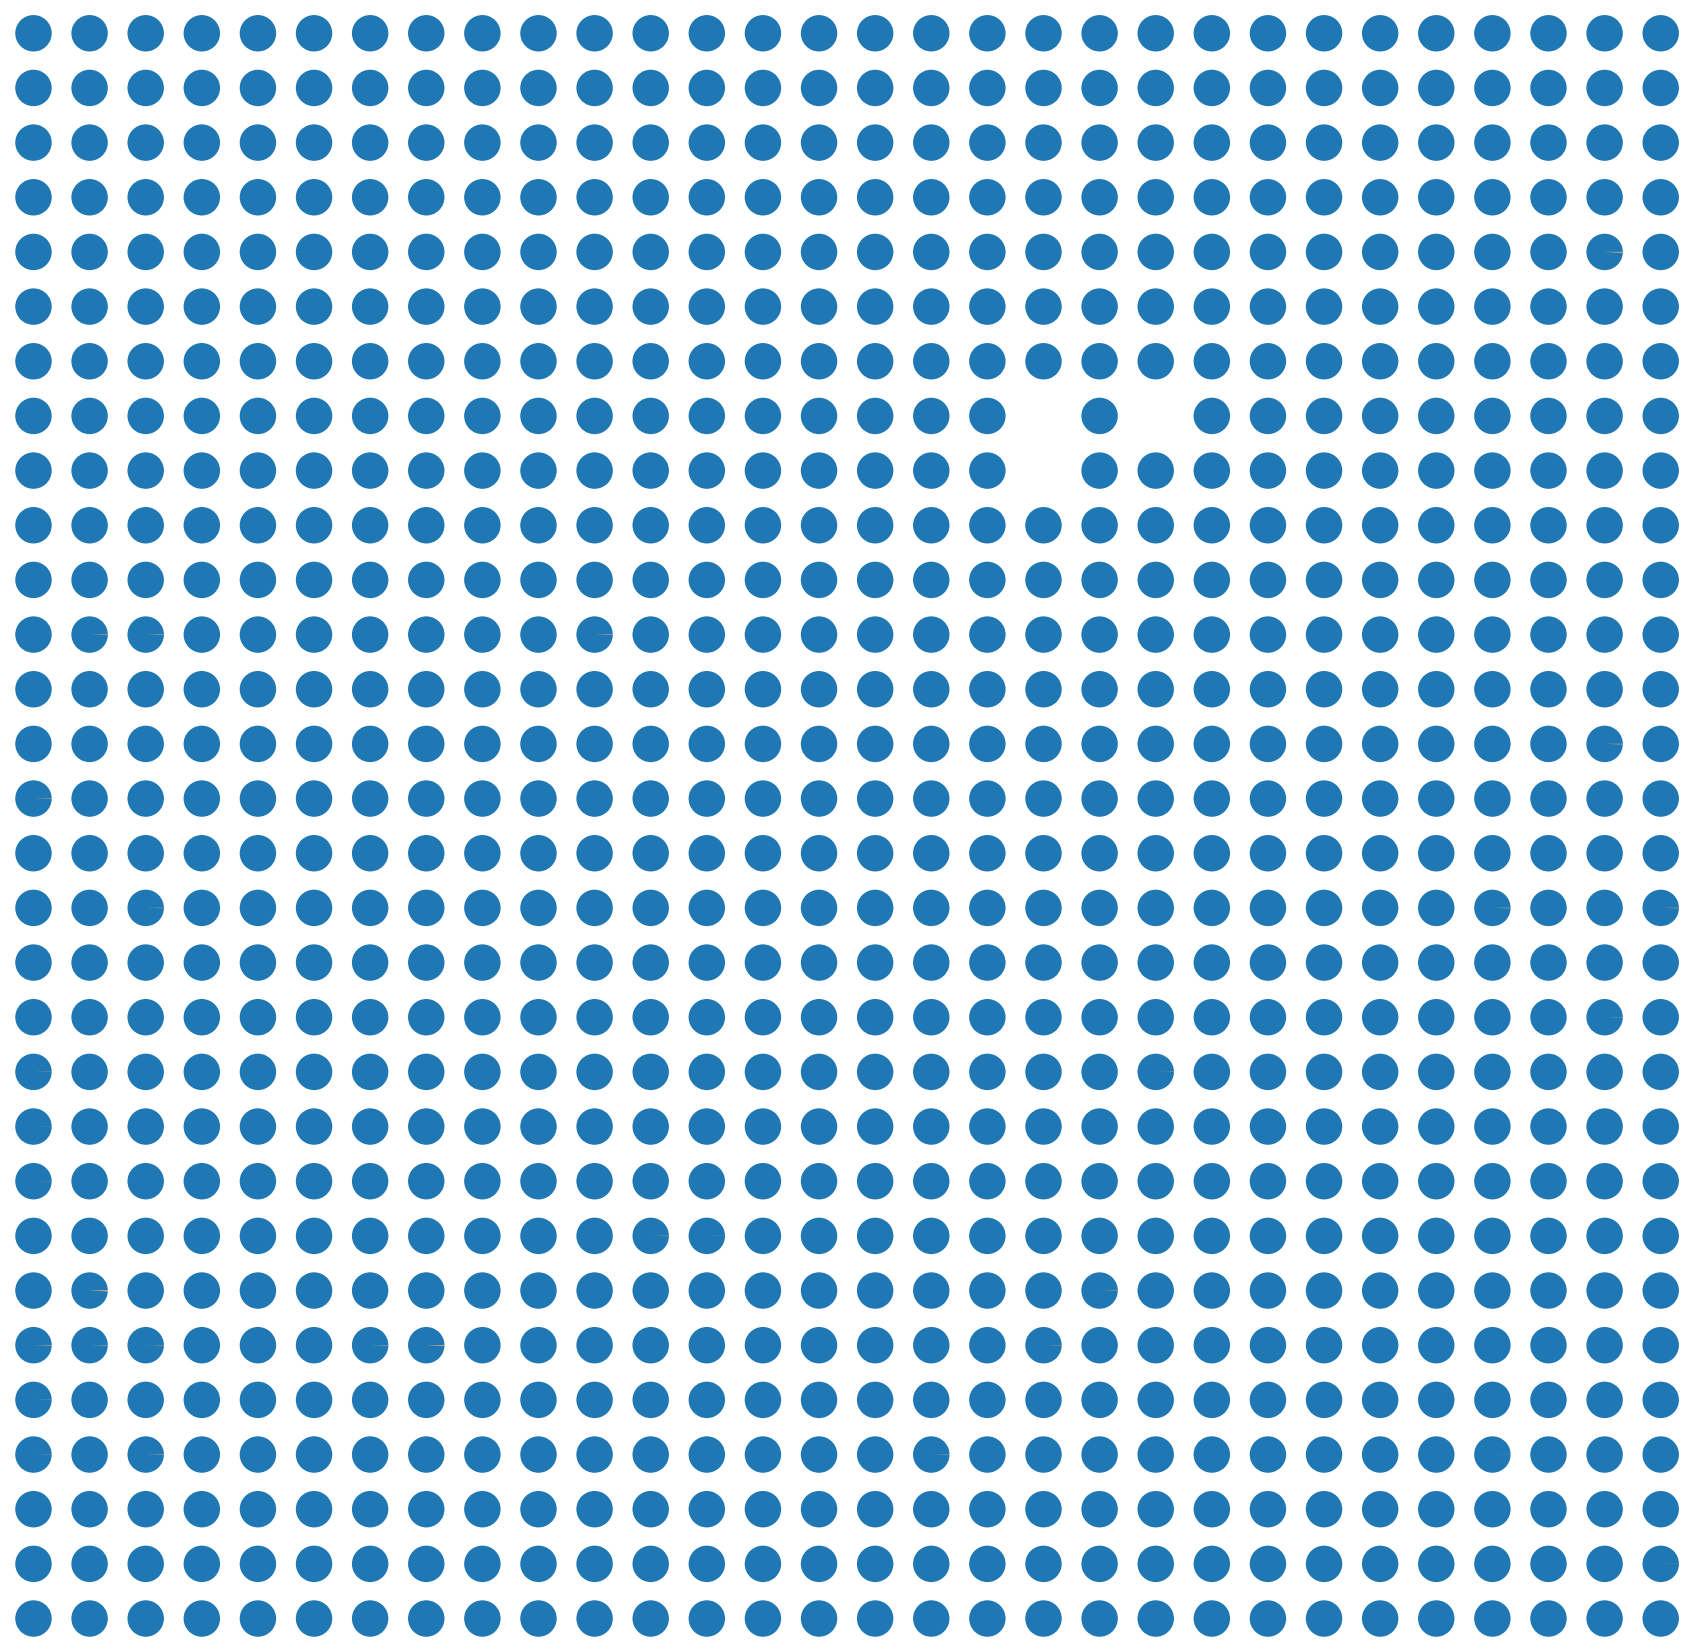

In [17]:
depict_som(combo_df,30,30,"X","Y","PUBCHEM_ACTIVITY_OUTCOME")

Ok, that clearly didn't work. All of our cells are colored blue, we aren't seeing any orange for the active molecules.  Hmmm, let's do what we should have done in the first place and see how many active molecules we have. 

In [18]:
Counter(combo_df.PUBCHEM_ACTIVITY_OUTCOME)

Counter({'Inactive': 334725, 'Active': 33})

Aha! Only 33 active molecules in 334 molecules screened.  That could be a problem.  It could be that the number of active molecules in any cell is so small that it won't show up.  Let's generate a table of only the SOM cells containing active molecules.  By comparing the number of active and inactive molecules, we can see get a better idea of whether this is the case. 

In [19]:
active_df = combo_df[combo_df.PUBCHEM_ACTIVITY_OUTCOME == "Active"].copy()
combo_gb_dict = dict([(a,b) for a,b in combo_df.groupby(["X","Y"])])
active_gb = active_df.groupby(["X","Y"])
df_list = []
for k,v in active_gb:
    x_pos,y_pos = k
    counts = Counter(combo_gb_dict[k].PUBCHEM_ACTIVITY_OUTCOME)
    num_active = counts.get("Active") or 0
    num_inactive = counts.get("Inactive") or 0
    df_list.append([x_pos,y_pos,num_active,num_inactive])
pd.DataFrame(df_list,columns=["X","Y","Active","Inactive"])

,X,Y,Active,Inactive
0,0,3,1,772
1,0,4,1,871
2,0,5,3,1032
3,0,8,1,1062
4,0,9,1,1535
5,0,10,1,703
6,0,15,1,430
7,1,5,1,522
8,1,6,1,148
9,1,18,1,339


Yup, as we suspected, the cell with the largest number of active compounds (3) only has 3/1032 actives.  This is probably too small to be depicted in a pie chart.

Let's try a different representation.  We will generate a heatmap of only the active compounds. We will generate a matrix of integers representing the number of active molecules in each cell.


In [20]:
som_matrix = np.zeros([30,30])
for [a,b],v in active_gb:
    som_matrix[a,b] = len(v)

Use the seaborn library to generate the heatmap.

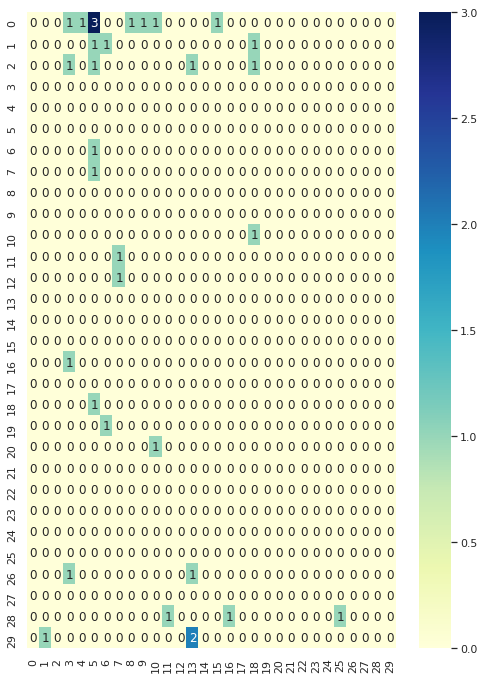

In [21]:
sns.set(rc={'figure.figsize':{11.7,8.27}})
sns.heatmap(som_matrix,annot=True,cmap="YlGnBu")

It does look like there are regions in the SOM that are enriched in active molecules.  Let's create a new column called "Pos" with the X and Y coordinates for the active molecules.  We will also sort the data frame with the active molecules by X and Y.

In [22]:
active_df["Pos"] = list(active_df["X"].map(str) + "," + active_df["Y"].map(str))
active_df.sort_values(["X","Y"],inplace=True)

Look at the active molecules as a table

In [23]:
active_df

,SMILES,PUBCHEM_SID,PUBCHEM_ACTIVITY_OUTCOME,X,Y,Pos
126301,OCCCNc1cc(-c2ccnc(Nc3cccc(Cl)c3)n2)ccn1,26731888,Active,0,3,"0,3"
126272,CC(C)n1cnc2c(Nc3cccc(Cl)c3)nc(NCCCO)nc21,26731917,Active,0,4,"0,4"
66113,CC(C)n1cnc2c(Nc3ccc(F)c(Cl)c3)nc(NCCO)nc21,49815812,Active,0,5,"0,5"
126274,CC[C@H](CO)Nc1nc(Nc2cccc(Cl)c2)c2ncn(C(C)C)c2n1,26731915,Active,0,5,"0,5"
126395,CC(C)n1cnc2c(Nc3cccc(Cl)c3)nc(N(CCO)CCCO)nc21,26731782,Active,0,5,"0,5"
133100,Nc1nc(Nc2cccc(Cl)c2)nc(NCCO)c1[N+](=O)[O-],26671622,Active,0,8,"0,8"
660,O=[N+]([O-])c1ccc2c(c1)-c1ccccc1C2=NO,93577001,Active,0,9,"0,9"
35704,O=C1NC(=O)C(c2ccccc2[N+](=O)[O-])=C1Nc1ccc(O)c(Cl)c1,56463775,Active,0,10,"0,10"
3359,Cc1nn(-c2nccs2)c2c1C(=O)CC(C)(C)C2Br,89855274,Active,0,15,"0,15"
228349,Clc1cncc(Cl)c1N/N=C/c1ccncc1,17510359,Active,1,5,"1,5"


Gemerate a grid with with Chemical structures sorted by, and labeled by, the X and Y coordinates in the SOM.

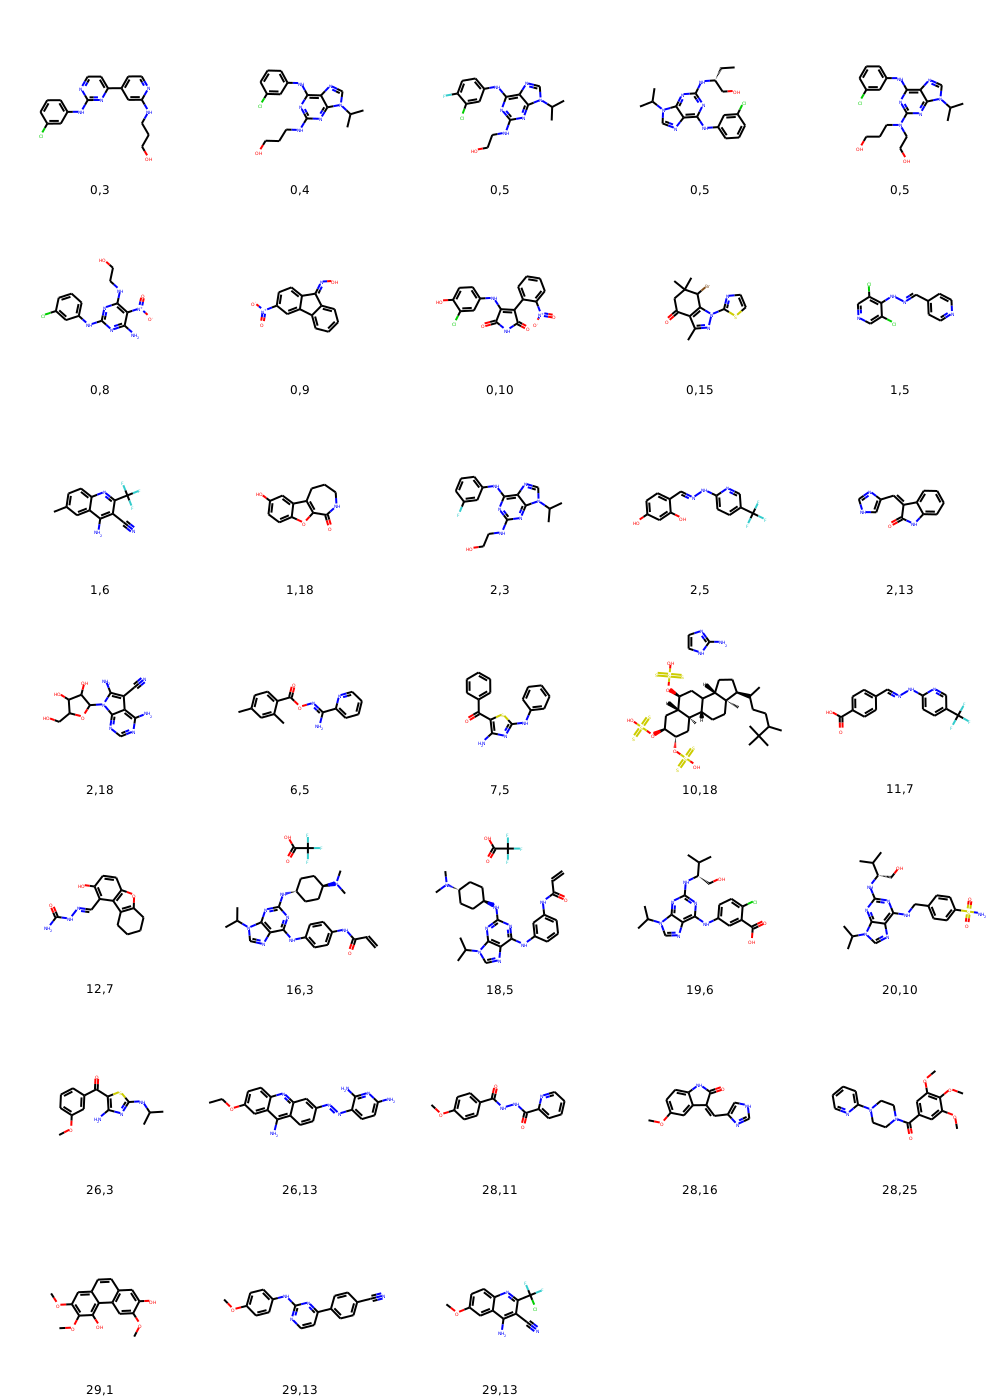

In [24]:
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in active_df.SMILES],molsPerRow=5,legends=list(active_df.Pos))

We can see a number areas where the SOM has grouped similar compounds toghether, this can provide the seeds for further exploration